# Imports
All imports should be defined here to reduce clutter

In [172]:
import numpy as np
import pygame
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import matplotlib.pyplot as plot

from NovelSwarmBehavior.novel_swarms.config.EvolutionaryConfig import GeneticEvolutionConfig
from NovelSwarmBehavior.novel_swarms.config.WorldConfig import RectangularWorldConfig
from NovelSwarmBehavior.novel_swarms.config.defaults import ConfigurationDefaults
from NovelSwarmBehavior.novel_swarms.novelty.GeneRule import GeneRule
from NovelSwarmBehavior.novel_swarms.config.OutputTensorConfig import OutputTensorConfig
from generation.HaltedEvolution import HaltedEvolution

# Function Declarations

In [173]:
def initializeHaltedEvolution():
    agent_config = ConfigurationDefaults.DIFF_DRIVE_AGENT

    genotype = [
        GeneRule(_max=1.0, _min=-1.0, mutation_step=0.4, round_digits=4),
        GeneRule(_max=1.0, _min=-1.0, mutation_step=0.4, round_digits=4),
        GeneRule(_max=1.0, _min=-1.0, mutation_step=0.4, round_digits=4),
        GeneRule(_max=1.0, _min=-1.0, mutation_step=0.4, round_digits=4),
    ]

    phenotype = ConfigurationDefaults.BEHAVIOR_VECTOR

    world_config = RectangularWorldConfig(
        size=(500, 500),
        n_agents=30,
        behavior=phenotype,
        agentConfig=agent_config,
        padding=15
    )

    novelty_config = GeneticEvolutionConfig(
        gene_rules=genotype,
        phenotype_config=phenotype,
        n_generations=100,
        n_population=100,
        crossover_rate=0.7,
        mutation_rate=0.15,
        world_config=world_config,
        k_nn=15,
        simulation_lifespan=600,
        display_novelty=False,
        save_archive=False,
        show_gui=True
    )

    pygame.init()
    pygame.display.set_caption("Evolutionary Novelty Search")
    screen = pygame.display.set_mode((world_config.w, world_config.h))

    output_config = OutputTensorConfig(
        timeless=True,
        total_frames=80,
        steps_between_frames=2,
        screen=screen
    )

    halted_evolution = HaltedEvolution(
        world=world_config,
        evolution_config=novelty_config,
        output_config=output_config
    )

    return halted_evolution

In [191]:
class BehaviorIdentificationModel(torch.nn.Module):
    def __init__(self, n_classes=2):
        super(BehaviorIdentificationModel, self,).__init__()

        self.n_classes = n_classes

        self.conv1 = torch.nn.Conv2d(1, 1, 5, stride=2, padding=2)
        self.activation1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(1, 1, 3, stride=2, padding=1)
        self.activation2 = torch.nn.ReLU()
        # self.conv3 = torch.nn.Conv2d(1, 1, 3, stride=2)
        # self.activation3 = torch.nn.LeakyReLU()

        self.pooling = torch.nn.MaxPool2d(2, stride=2)
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(3844, 400)
        self.activation5 = torch.nn.ReLU()

        FEATURE_LAYER_SIZE = 100
        self.linear2 = torch.nn.Linear(400, FEATURE_LAYER_SIZE)
        self.activation6 = torch.nn.ReLU()
        self.classification_layer = torch.nn.Linear(FEATURE_LAYER_SIZE, self.n_classes)

        self.curr_feature_layer = torch.zeros(FEATURE_LAYER_SIZE)


    def forward(self, x):
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.activation2(x)
        # print(x.size())
        # x = self.conv3(x)
        # x = self.activation3(x)

        x = self.pooling(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.activation5(x)
        x = self.linear2(x)

        # Save Features
        self.curr_feature_layer = x

        x = self.activation6(x)
        x = self.classification_layer(x)
        return x

    def increaseClassCount(self):
        self.n_classes += 1
        self.classification_layer = torch.nn.Linear(100, self.n_classes)

# Test Halted Evolution + TensorBoard
The following initializes a possible evolution, simulates the genome, and outputs the resulting frame to tensorboard

In [175]:
def testTensorBoardAndEvolutionNexting():
    # Writer will output to ./runs/ directory by default
    writer = SummaryWriter()

    evolution = initializeHaltedEvolution()
    evolution.evolve_config.lifespan = 1200
    evolution.setup()

    for i in range(60):
        frame, behavior_vector = evolution.next()
        frame = frame.astype(np.uint8)
        reshaped = np.reshape(frame, (1, 500, 500))

        # Tensorboard output
        writer.add_image('images', reshaped.astype(np.uint8), i, dataformats="CWH")

    writer.close()
    pygame.quit()

# testTensorBoardAndEvolutionNexting()

# Test Single Pass Through of the Network

In [179]:
def testInputAndBackpropOfAlteredNetwork():
    evolution = initializeHaltedEvolution()
    evolution.setup()

    model = BehaviorIdentificationModel(n_classes=6)
    frame, _ = evolution.next()
    frame = frame.astype(np.uint8)
    reshaped = np.reshape(frame, (1, 500, 500))

    # Initialize a test loss function
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

    tensor = torch.tensor(reshaped, dtype=torch.float32)
    y_hat1 = model.forward(tensor)
    print(y_hat1)

    y_truth = torch.tensor([[1, 0, 0, 0, 0, 0]], dtype=torch.float32)
    loss = loss_fn(y_hat1, y_truth)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.increaseClassCount()
    y_hat2 = model.forward(tensor)
    y_truth = torch.tensor([[1, 0, 0, 0, 0, 0, 0]], dtype=torch.float32)
    loss = loss_fn(y_hat2, y_truth)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(y_hat1, y_hat2)
    pygame.quit()
# testInputAndBackpropOfAlteredNetwork()

Get Number of trainable parameters in the network

In [177]:
def printModelInformation():
    model_info = BehaviorIdentificationModel(n_classes=2)
    print(sum(p.numel() for p in model_info.parameters() if p.requires_grad))
    print(f"Model structure: {model_info}\n\n")
printModelInformation()

1578338
Model structure: BehaviorIdentificationModel(
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (activation1): LeakyReLU(negative_slope=0.01)
  (conv2): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (activation2): LeakyReLU(negative_slope=0.01)
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=3844, out_features=400, bias=True)
  (activation5): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=400, out_features=100, bias=True)
  (activation6): LeakyReLU(negative_slope=0.01)
  (classification_layer): Linear(in_features=100, out_features=2, bias=True)
)




In [218]:
data_transform_training = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomApply(
        transforms=[
            transforms.RandomAffine(
                degrees=(0, 180),
                translate=(0.0, 0.3),
                scale=(0.5, 1.0)
            ),
            transforms.RandomPerspective(
                distortion_scale=0.6,
                p = 0.3
            )
        ],
        p=1.0
    ),
    transforms.ToTensor(),
])

data_transform_testing = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

train_folder = torchvision.datasets.ImageFolder(root="./data/train", transform=data_transform_training)
test_folder = torchvision.datasets.ImageFolder(root="./data/test", transform=data_transform_testing)

train_folder = torch.utils.data.ConcatDataset([train_folder] * 8)

train_loader = torch.utils.data.DataLoader(
    train_folder,
    batch_size=1,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_folder,
    batch_size=4,
    shuffle=True
)

In [219]:
def custom_softmax(x):
    alpha = torch.tensor(0.0)
    # print("Alpha: ", alpha)
    exp_x = torch.exp(x)
    # print("Exp X: ", exp_x)
    sum_x = torch.sum(exp_x, dim=1, keepdim=True) + torch.exp(alpha)
    # print("Sum X: ", sum_x)
    softmax = exp_x / sum_x
    # print("Sofmax: ", softmax)
    return softmax

def custom_log_softmax(x):
    return torch.log(custom_softmax(x))

def custom_cross_entropy_loss(x, y_truth):
    log_prob = -1.0 * custom_log_softmax(x)
    # print("Log Prob: ", log_prob)
    loss = log_prob.gather(1, y_truth.unsqueeze(1))
    # print("Gathering: ", loss)
    loss = loss.mean()
    # print("Loss: ", loss)
    return loss

def entropic_open_set_loss(x, y_truth=None, in_distribution=True):
    if in_distribution:
        return custom_cross_entropy_loss(x, y_truth)
    else:
        return (-1/len(x)) * torch.sum(custom_log_softmax(x))

def objectosphere_loss(x, y_truth=None, feature_layer=None, in_distribution=True):
    entropic_loss = entropic_open_set_loss(x, y_truth=y_truth, in_distribution=in_distribution)
    LAMBDA = 0.4
    if in_distribution:
        ZETA = 1.0
        objectosphere = max(torch.max(ZETA - torch.norm(feature_layer)), torch.tensor(0)) ** 2
    else:
        objectosphere = torch.norm(feature_layer) ** 2

    return entropic_loss + (LAMBDA * objectosphere)

In [217]:
test = torch.tensor([[0.5, 0.44], [0.8, 0.22]])
y_truth = torch.tensor([0, 1])
features = torch.rand((2,3))
print("Test: ", test)
print("Y Truth: ", y_truth)
print("Features: ", features)

print("ID_Entropic: ", entropic_open_set_loss(test, y_truth=y_truth, in_distribution=True))
print("OOD_Entropic: ", entropic_open_set_loss(test, in_distribution=False))
print("ID_Objectosphere: ", objectosphere_loss(test, y_truth=y_truth, feature_layer=features, in_distribution=True))
print("OOD_Objectosphere: ", objectosphere_loss(test, feature_layer=features, in_distribution=False))

Test:  tensor([[0.5000, 0.4400],
        [0.8000, 0.2200]])
Y Truth:  tensor([0, 1])
Features:  tensor([[0.2671, 0.4131, 0.9857],
        [0.9584, 0.0637, 0.0264]])
ID_Entropic:  tensor(1.1066)
OOD_Entropic:  tensor(1.9532)
ID_Objectosphere:  tensor(1.1066)
OOD_Objectosphere:  tensor(2.8079)


In [ ]:
OOD_CLASS = 2
epochs = 100
model = BehaviorIdentificationModel(n_classes=2)

loss_fn = custom_cross_entropy_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

writer = SummaryWriter()

for epoch in range(epochs):
    print(f"Epoch {epoch}")

    # Training
    size = len(train_loader.dataset)
    loss_sum = 0
    for batch, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        pred = model(X)
        features = model.curr_feature_layer
        if y[0] == OOD_CLASS:
            loss = entropic_open_set_loss(pred, y_truth=y, in_distribution=False)
        else:
            loss = entropic_open_set_loss(pred, y_truth=y, in_distribution=True)
        loss.backward()
        loss_sum += loss.item()
        optimizer.step()

    epoch_loss = loss_sum / len(train_loader)
    writer.add_scalar('Loss/Train', epoch_loss, global_step=epoch)
    print(f"Training loss: {epoch_loss:>7f}")

    # Testing (Only test every few epochs)
    if epoch % 1 == 0:
        size = len(test_loader.dataset)
        num_batches = len(test_loader)
        test_loss, accuracy = 0, 0

        with torch.no_grad():
            for X, y in test_loader:
                pred = model(X)
                loss = loss_fn(pred, y)
                test_loss += loss.item()
                softy = custom_softmax(pred)

                for i, row in enumerate(softy):
                    if row.argmax() == y[i]:
                        accuracy += 1

            print("Softmax Values: ", softy)

            # print(pred, softy)

        test_loss /= num_batches
        accuracy /= size
        print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        writer.add_scalar('Loss/Test', test_loss, global_step=epoch)
        writer.add_scalar('Accuracy/Test', accuracy, epoch)


Epoch 0
Training loss: 0.731642
Softmax Values:  tensor([[0.4385, 0.5589],
        [0.4385, 0.5589]])
Test Error: 
 Accuracy: 51.8%, Avg loss: 0.696840 

Epoch 1
Training loss: 0.717073
Softmax Values:  tensor([[0.4165, 0.5800],
        [0.4165, 0.5800]])
Test Error: 
 Accuracy: 51.8%, Avg loss: 0.707442 

Epoch 2
Training loss: 0.718392
Softmax Values:  tensor([[0.4948, 0.5018],
        [0.4948, 0.5018]])
Test Error: 
 Accuracy: 51.8%, Avg loss: 0.696311 

Epoch 3
Training loss: 0.717681
Softmax Values:  tensor([[0.6231, 0.3759],
        [0.6231, 0.3759]])
Test Error: 
 Accuracy: 48.2%, Avg loss: 0.738782 

Epoch 4
Training loss: 0.716653
Softmax Values:  tensor([[0.4973, 0.4963],
        [0.4973, 0.4963]])
Test Error: 
 Accuracy: 48.2%, Avg loss: 0.699612 

Epoch 5
Training loss: 0.714765
Softmax Values:  tensor([[0.5976, 0.4014],
        [0.5976, 0.4014]])
Test Error: 
 Accuracy: 48.2%, Avg loss: 0.720732 

Epoch 6
Training loss: 0.713697
Softmax Values:  tensor([[0.5140, 0.4845],
 

Starting


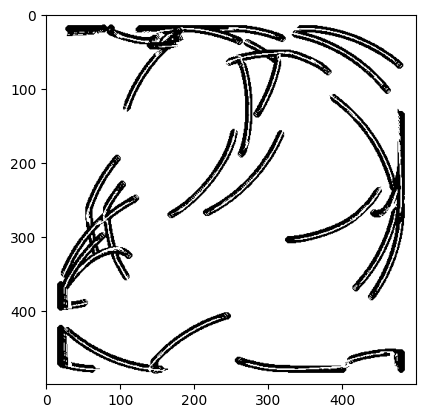

Prediction:  tensor([[ 96.9236, 101.9596]]) Target:  None
SoftMaxed:  tensor([[nan, nan]])
Ending


In [190]:
print("Starting")
import matplotlib.pyplot as plot

eval_folder = torchvision.datasets.ImageFolder(root="./data/eval", transform=data_transform_testing)
eval_loader = test_loader = torch.utils.data.DataLoader(
    eval_folder,
    batch_size=4,
    shuffle=False
)

with torch.no_grad():
    X, y = eval_loader.dataset[5]

    plot.imshow(torch.squeeze(X), cmap='Greys')
    plot.show()

    pred = model(X)
    # target = torch.tensor([y])
    print("Prediction: ", pred, "Target: ", None)

    # optimizer.zero_grad()
    #
    # test_loss = loss_fn(pred, target)
    # print("Loss: ", test_loss.item())

    softy = custom_log_softmax(pred)
    print("SoftMaxed: ", softy)

print("Ending")